02. RAG 1단계: 데이터 인덱싱

- 1장에서는 랭체인으로 LLM 애플리케이션을 구축하는 데 필요한 구성 요소를 살펴보고 LLM이 프롬프트를 전송 받아 답변하는 간단한 챗봇 AI를 구축함, 하지만 이 단순한 챗봇에는 큰 한계가 있음
- LLM이 학습하지 않은 지식이 필요하다면 어떻게 해야 할까? 예를 들어 회사 내부에서 필요한 질문에 AI를 사용한다고 가정하면, 정보를 비공개 PDF 파일 같이 내부 문서에 담겨 있음, 최근 모델 제공업체들이 지속적으로 저장 형식과 관계없이 전 세계의 공개 정보를 학습 데이터셋에 반영하는 가운데, LLM의 지식 코퍼스에는 여전히 두 가지 한계가 존재
    - 비공개 데이터: 공개되지 않은 정보는 당연히 LLM의 훈련 데이터에 포함되지 않음
    - 현재 정보: LLM 학습은 상당한 비용이 소요되며 오랜시간이 필요한 과정, 학습은 수년에 걸쳐 진행되기도 하며, 학습 초기 단계에는 데이터 수집을 수행, 이에 따라 LLM이 현재 정보를 보유하지 못하난 기준 날짜인 지식 컷오프가 발생, 보통 학습 데이터셋이 최종 확정된 날짜가 지식 컷오프가 됨, 대상 모델에 따라 기준 시점은 과거 몇 달 전일수도, 몇 년 전일수도 있음

- 어느 경우든, LLM은 환각(잘못된 정보를 출력하는 현상)을 일으키고 부정확한 정보를 제공한 가능성이 높음, 이는 프롬프트를 수정해도 해결되지 않음, 모델의 지식 한계로 인해 생기는 문제

2.1. 목표: LLM을 위한 적절한 컨텍스트 선정

- 만약 LLM 활용에 필요한 비공개/최신 데이터가 한두 페이지 분량의 텍스트라면 큰 문제는 없음, 프롬프트에 해당 텍스트 전체를 포함하면 충분
- LLM에 데이터를 제공할 때 가장 문제가 되는 요소는 바로 입력 크기 제한, 분명 가지고 있는 정보는 프롬프트에 입력할 수 있는 범위를 초과할 가능성이 큼, 방대한 텍스트는 LLM에 전부 전달할 수는 없기 때문에, 특정 부분만 선택해야 하는 데 어느 부분을 전달해야 할지 결정 필요, LLM이 질문에 답할 때 참소하기에 가장 적합힙 텍스트는 어떻게 선정해야 할지 결정 필요
    1. 인덱싱: 애플리케이션이 질문에 가장 적합한 자료를 손쉽게 탐색할 수 있도록 문서를 전처리
    2. 검색: LLM이 데이터를 바탕으로 정확한 답변을 생성하도록 인덱스에서 외부 데이터를 가져와 컨텍스트로 전달
- 이번 장에서는 첫 번째 단계인 인덱싱에 초점을 맞추며, 문서를 거대 언어 모델이 이해하고 검색할 수 있는 형식으로 사전 처리하는 과정을 다룸, 이 기술을 검색 증강 생성(RAG)이라 함, 본격적으로 나아가기에 앞서, 문서 전ㅇ처리가 필요한 이유를 살펴보자.

- LLM을 활용한 테슬라의 2022년 연례보고서(https://oreil.ly/Bp51E)에 담긴 재무 성과와 위험 요소를 분석하려 한다. 해당 보고서는 PDF 형식으로 저장되어 있음 "2022년 테슬라가 직면한 주요 위험은 무엇인가?"와 같은 질문에 문서 내 위험 요소 부분을 기반으로 인간이 할 법한 답변을 받아야 함, 이를 위해 네가지 핵심 단계가 필요, 아래 그림 참조
- 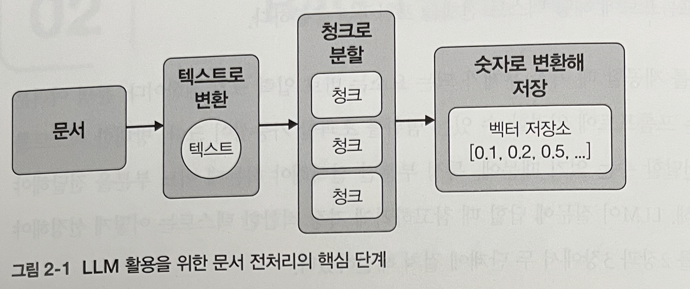
    1. 문서에서 텍스트를 추출
    2. 텍스트를 효율적으로 처리할 수 있도록 적절한 단위로 분할
    3. 텍스트를 컴퓨터가 이해할 수 있는 숫자 체계로 변환
    4. 문서에서 주어진 질문에 대한 부분을 손쉽고 신속하게 조회할 수 있도록, 텍스트의 숫자 표현을 적잘한 위치에 저장

- 위 그림은 문서를 전처리하고 변환하는 과정, 이 과정을 인제스천이라고 부름, 인제스천은 문서를 컴퓨터가 이해하고 분석하기 좋은 숫자 데이터로 전환한 뒤, 이를 효율적인 검색 증감 생성을 위해 특화된 데이터베이스에 저장, 여기서 숫자 데이터는 임베딩이라 부름, 특수한 유형의 데이터베이스를 벡터 저장소라 부름, 이제 임베딩이 무엇인지 왜 중요한지, LLM 기반 임베딩보다 더 간단한 기초적인 임베딩부터 자세히 진행

- 2.2. 임베딩: 텍스트를 숫자로 변환
    - 임베딩은 텍스트를 (긴) 숫자 시퀀스로 표현, 이 과정에서 손실이 발생, 숫자 시퀀스에서 원본 텍스트를 복원할 수 없음, 따라서 원본텍스트와 해당 숫자 시퀀스를 함께 저장
    - 원본 텍스트를 저장하는 데 굳이 숫자 데에